In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

batch_size = 32

# Define transformations for the training set with data augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Define transformations for the testing set without data augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # Normalize the images
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# a DataLoader for the training dataset
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# a DataLoader for the testing dataset
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [3]:
class VGGBlock(torch.nn.Module):
    def __init__(self, input_channels, output_channels, num_convs):
        super(VGGBlock, self).__init__()
        self.num_convs = num_convs

        self.block = []

        for i in range(self.num_convs):
            self.block.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
            input_channels = output_channels

            self.block.append(torch.nn.ReLU())

        self.block.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.block = torch.nn.ModuleList(self.block) # Ensures that each module in the list is considered a submodule of this module

    def forward(self, x):
        for module in self.block:
            x = module(x)

        return x


In [8]:
class VGGNet(torch.nn.Module):
    def __init__(self, conv_arch, num_outputs):
        super(VGGNet, self).__init__()

        self.conv_arch = conv_arch
        self.num_outputs = num_outputs

        input_channels = 3
        modules = []

        for output_channels, num_convs in conv_arch:
            modules.append(VGGBlock(input_channels, output_channels, num_convs))
            input_channels = output_channels

        modules.append(torch.nn.Flatten())
        modules.append(torch.nn.Linear(input_channels, 4096)) # Assuming 1 x 224 x 224 input images and 5 blocks
        modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Dropout())
        modules.append(torch.nn.Linear(4096, 4096))
        modules.append(torch.nn.ReLU())
        modules.append(torch.nn.Dropout())
        modules.append(torch.nn.Linear(4096, num_outputs))

        self.vgg_modules = torch.nn.ModuleList(modules) # Ensures that each module in the list is considered a submodule of this module

    def forward(self, x):
        for module in self.vgg_modules:
            x = module(x)

        return x

In [9]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

conv_arch = [(64, 2), (128, 2), (256, 3), (512, 3), (512, 3)] # Adapted VGG-16 architecture (fewer convolutional filters per block)

model = VGGNet(conv_arch, 10).to(device) # Creates and moves the model to `device`
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

VGGNet(
  (vgg_modules): ModuleList(
    (0): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): VGGBlock(
      (block): ModuleList(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(2

In [10]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = 0.
    n = 0.
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return float(c / n) * 100

# Visualisation of model training & testing processes


Epoch 1/30.
Loss:2.012 Training accuracy: 20.57%. Testing accuracy: 20.91%. Duration: 38.894s.

Epoch 2/30.
Loss:1.7756 Training accuracy: 35.13%. Testing accuracy: 34.95%. Duration: 37.835s.

Epoch 3/30.
Loss:1.5516 Training accuracy: 47.29%. Testing accuracy: 46.47%. Duration: 38.905s.

Epoch 4/30.
Loss:1.3699 Training accuracy: 54.70%. Testing accuracy: 53.97%. Duration: 39.699s.

Epoch 5/30.
Loss:1.2233 Training accuracy: 61.99%. Testing accuracy: 59.87%. Duration: 39.015s.

Epoch 6/30.
Loss:1.1903 Training accuracy: 61.51%. Testing accuracy: 60.00%. Duration: 40.739s.

Epoch 7/30.
Loss:1.0563 Training accuracy: 67.71%. Testing accuracy: 64.92%. Duration: 39.450s.

Epoch 8/30.
Loss:0.9758 Training accuracy: 70.20%. Testing accuracy: 66.28%. Duration: 38.771s.

Epoch 9/30.
Loss:0.9478 Training accuracy: 72.84%. Testing accuracy: 68.85%. Duration: 39.241s.

Epoch 10/30.
Loss:0.8929 Training accuracy: 72.38%. Testing accuracy: 67.87%. Duration: 39.527s.

Epoch 11/30.
Loss:0.8883 Trai

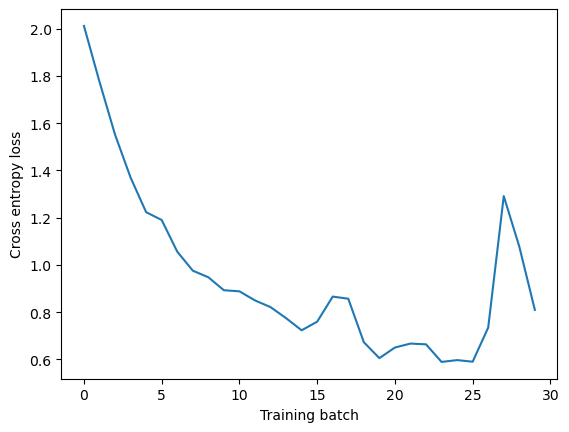

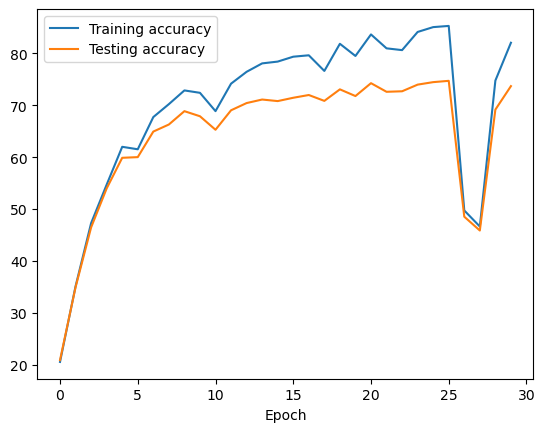

In [11]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 30
for epoch in range(num_epochs):
    total_loss=0
    correct_cnt=0
    
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()
    
    model.train()
    
    for images, labels in train_iter:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        predict = model(images)
        l = criterion(predict, labels)
        l.backward()
        optimizer.step()
        total_loss += l.item() *images.shape[0]

    loss = round(total_loss / len(train_iter.dataset), 4)
    losses.append(loss)

    
    with torch.no_grad(): # Computing performance metrics does not require gradients
        model.eval()
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct)) #compute accuracy in the testing dataset

        end_time = time.perf_counter()
        print(f'Loss:{loss} Training accuracy: {train_accs[-1]:.2f}%. Testing accuracy: {test_accs[-1]:.2f}%. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.



plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()


plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

# confusion matrix

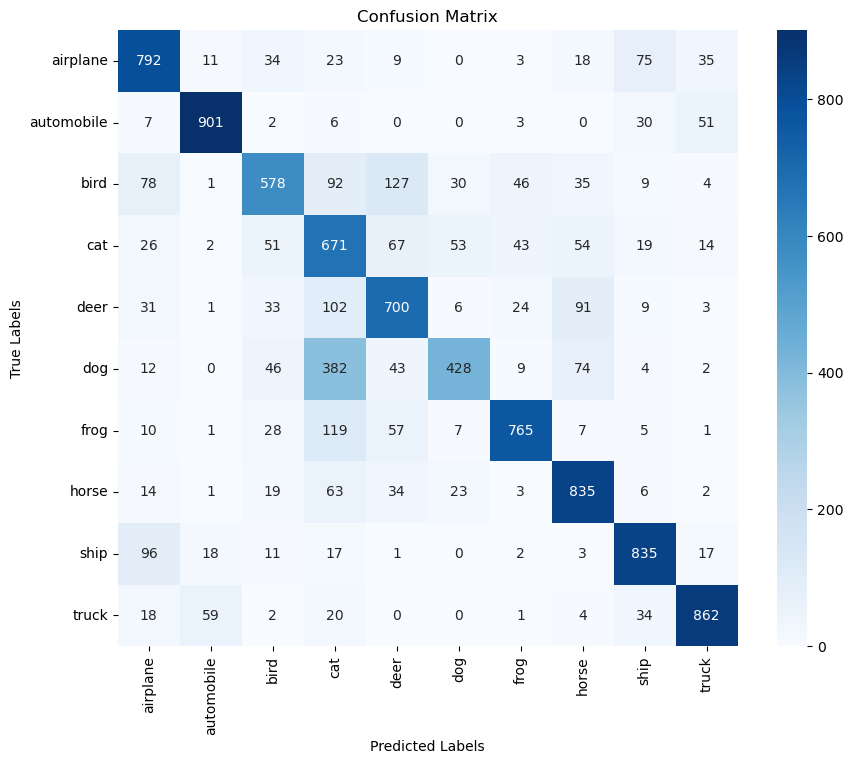

In [12]:
classes = train_dataset.classes
all_preds = []
all_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
def imshow(images, labels, predicted):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 3))
    for i, (img, label, pred) in enumerate(zip(images, labels, predicted)):
        img = img / 2 + 0.5
        npimg = img.cpu().numpy()
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i].set_title(f'True: {classes[label]}\nPredicted: {classes[pred]}')
        axs[i].axis('off')
    plt.show()

correct_images, correct_labels, correct_predicted = [], [], []
incorrect_images, incorrect_labels, incorrect_predicted = [], [], []

with torch.no_grad():
    model.eval()
    for images, labels in test_iter:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        for img, label, pred in zip(images, labels, predicted):
            if pred == label and len(correct_images) < 5:
                correct_images.append(img)
                correct_labels.append(label.item())
                correct_predicted.append(pred.item())
            elif pred != label and len(incorrect_images) < 5:
                incorrect_images.append(img)
                incorrect_labels.append(label.item())
                incorrect_predicted.append(pred.item())
            if len(correct_images) >= 5 and len(incorrect_images) >= 5:
                break
        if len(correct_images) >= 5 and len(incorrect_images) >= 5:
            break


# Image examples of success cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Correctly Classified Images


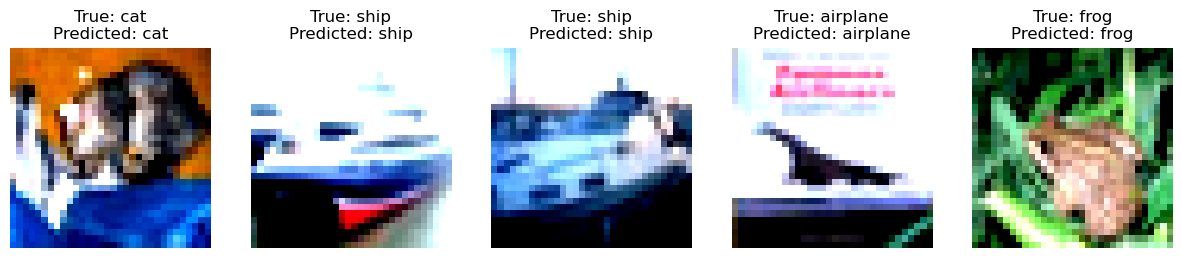

In [14]:
print('Correctly Classified Images')

if len(correct_images) >= 5:
    imshow(correct_images, correct_labels, correct_predicted)

# Image examples of failure cases

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Incorrectly Classified Images


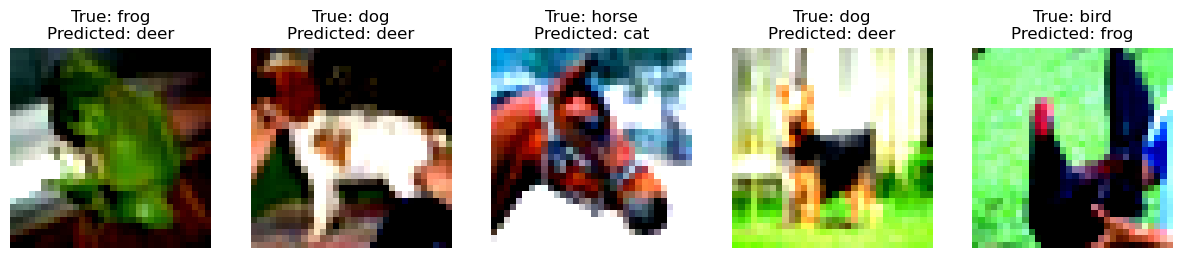

In [15]:
print("Incorrectly Classified Images")

if len(incorrect_images) >= 5:
    imshow(incorrect_images, incorrect_labels, incorrect_predicted)